In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def f(x):
    return 4*x**2 - 3*x + 2

print (f(2))

12


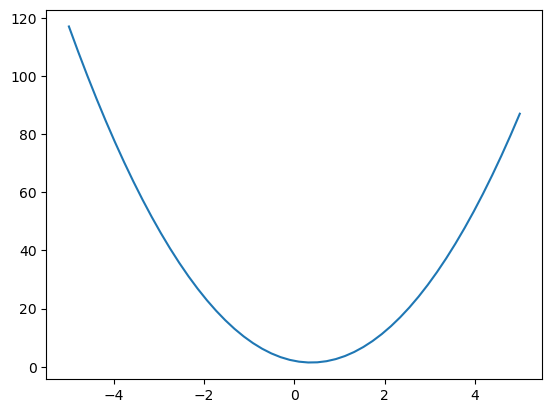

In [3]:
xs = np.linspace(-5, 5)
ys = f(xs)

plt.plot(xs, ys)

In [24]:
class Value:

    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = backward
        
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other
    
    def exp (self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def backward():
            self.grad += out.data * out.grad
        out._backward = backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
        def backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = backward
        return out
    
    def backward(self):
        self.grad = 1
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()


In [26]:
a = Value (2.0)
a * 2
a + 2
2 * a
3 + a

Value(data=5.0)

In [5]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': "LR"}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # connect this node to it
            dot.edge(uid + n._op, uid)
            # print (n, uid + n._op, " ", uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot    


In [12]:
# add a neuron

In [13]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value (-3.0, label='w1')
w2 = Value (1.0, label='w2')

#bias of the neuron
b1 = Value(6.8813735870195432, label='b1')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b1; n.label = 'n'
o = n.tanh()
o.label = "o"

In nodes set--------


In edges set--------


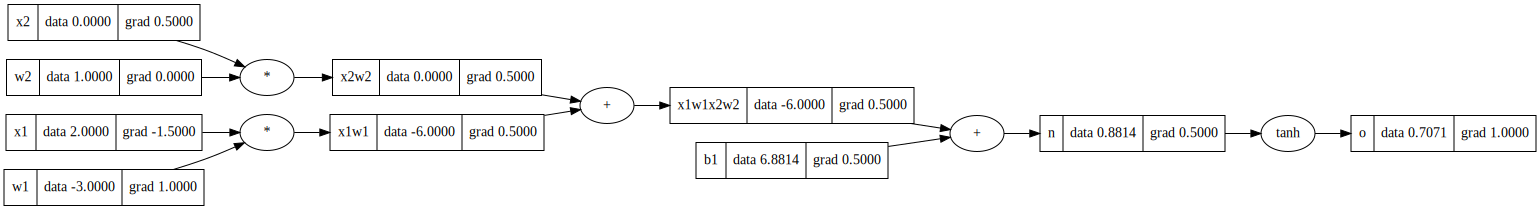

In [15]:
o.backward()
draw_dot(o)